<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод." data-toc-modified-id="Вывод.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод.</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
#from fast_ml.model_development import train_valid_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, recall_score, precision_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
#Считываем данные из csv-файла в датафрейм
try:
    data = pd.read_csv('/datasets/Churn.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [3]:
#Функция получения первичной информации о датафрейме
def studying_the_data (data):
    print ('------------- Первые 5 строк ------------')
    display(data.head())
    print('')
    print('')
    print ('------------- Типы данных ------------')
    print (data.info())
    print('')
    print('')
    print ('------------- Пропуски ------------')
    count = 0
    for element in data.columns:
        if data[element].isna().sum() > 0: 
            print(element, ' - ', data[element].isna().sum(), 'пропусков')
            count = +1
        if count == 0:
            print(element, 'Пропусков НЕТ')
    print('')
    print('')
    print ('------------- Дубликаты ------------')
    if data.duplicated().sum() > 0:
        print('Дубликатов: ', data.duplicated().sum())
    else:
        print('Дубликатов НЕТ')

studying_the_data (data)

------------- Первые 5 строк ------------


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


------------- Пропуски ------------
RowNumber 

In [4]:
#Заменим пропуски в Tenure медианным значением
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
#Удалим столбецы Surname, RowNumber, CustomerId
data = data.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)

In [6]:
print(data.head())

   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42     2.0       0.00              1   
1          608     Spain  Female   41     1.0   83807.86              1   
2          502    France  Female   42     8.0  159660.80              3   
3          699    France  Female   39     1.0       0.00              2   
4          850     Spain  Female   43     2.0  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0  


In [7]:
#Преобразуем колонки Geography и Gender техникой OHE. Чтобы не попасть в дамми-ловушку, применим аргумент drop_first 
#функции pd.get_dummies() и выведем обновленную таблицу
data = pd.get_dummies(data, columns=['Geography', 'Gender'], drop_first= True)
print(data.head())

   CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42     2.0       0.00              1          1   
1          608   41     1.0   83807.86              1          0   
2          502   42     8.0  159660.80              3          1   
3          699   39     1.0       0.00              2          0   
4          850   43     2.0  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0               1        101348.88       1                  0   
1               1        112542.58       0                  0   
2               0        113931.57       1                  0   
3               0         93826.63       0                  0   
4               1         79084.10       0                  0   

   Geography_Spain  Gender_Male  
0                0            0  
1                1            0  
2                0            0  
3                0            0  
4                1            

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Изучу, спасибо</font>
</div>

In [8]:
#Стандартизируем признаки, применим масштабирование
#Для этого сначала выделим целевой признак и оставшиеся признаки и сохраним их в переменные
target = data['Exited']
features = data.drop('Exited', axis=1)

#Разделим исходные данные на обучающую, валидную и тестовую выборки в соотношении 3:1:1
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.40, random_state=12345) 

features_valid, features_test, target_valid, target_test = train_test_split(features_test, target_test, 
                                                                            test_size=0.50, random_state=12345) 

print(features_train.shape)
print(target_train.shape[0])
print(features_valid.shape)
print(target_valid.shape[0])
print(features_test.shape)
print(target_test.shape[0])

(6000, 11)
6000
(2000, 11)
2000
(2000, 11)
2000


In [9]:
import warnings
warnings.filterwarnings('ignore')

#Стандартизируем признаки, применим масштабирование
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

#Создадим объект структуры StandardScaler и настроим его на обучающих данных. 
#Настройка — это вычисление среднего и дисперсии
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 

#Преобразуем обучающую, валидационную и тестовую выборки функцией transform(). 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 
features_test[numeric] = scaler.transform(features_test[numeric])

#Чтобы предупреждение не появлялось
pd.options.mode.chained_assignment = None

print(features_train.head())

      CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
7479    -0.886751 -0.373192  1.082277  1.232271              1          1   
3411     0.608663 -0.183385  1.082277  0.600563              1          0   
6027     2.052152  0.480939 -0.737696  1.027098              2          0   
1247    -1.457915 -1.417129  0.354288 -1.233163              2          1   
3716     0.130961 -1.132419 -1.101690  1.140475              1          0   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
7479               0        -0.187705                  0                1   
3411               0        -0.333945                  0                0   
6027               1         1.503095                  1                0   
1247               0        -1.071061                  0                0   
3716               0         1.524268                  1                0   

      Gender_Male  
7479            1  
3411            0  
6027          

### Вывод. 
Данные подготовили, переходим к исследованиям

## Исследование задачи

0    7963
1    2037
Name: Exited, dtype: int64


<AxesSubplot:title={'center':'Баланс классов'}>

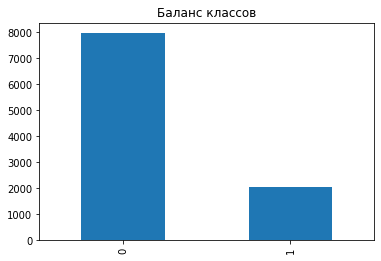

In [10]:
#Посмотрим на баланс классов
class_frequency = target.value_counts()
print(class_frequency)

plt.figure();
class_frequency.plot(kind='bar', title='Баланс классов')

Классы несбалансированны, так как их соотношение далеко от 1:1

In [11]:
#Построим модель решающего дерева
for depth in range(1, 16, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучим модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучим модель вызовом метода fit()
    predicted_valid = model.predict(features_valid) # получим предсказания модели
    print('depth', depth, 'f1', f1_score(target_valid, predicted_valid))  

depth 1 f1 0.0
depth 2 f1 0.5217391304347825
depth 3 f1 0.4234875444839857
depth 4 f1 0.5528700906344411
depth 5 f1 0.5406249999999999
depth 6 f1 0.5696969696969697
depth 7 f1 0.5320813771517998
depth 8 f1 0.5454545454545454
depth 9 f1 0.5633802816901409
depth 10 f1 0.5385694249649369
depth 11 f1 0.5059920106524634
depth 12 f1 0.521072796934866
depth 13 f1 0.5038961038961038
depth 14 f1 0.48675914249684743
depth 15 f1 0.4975124378109453


Наилучший показатель f1 = 0,57 при depth 9

In [12]:
model = DecisionTreeClassifier(random_state=12345, max_depth=9) # обучим модель с заданной глубиной дерева
model.fit(features_train, target_train) # обучим модель вызовом метода fit()
probabilities = model.predict_proba(features)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target, probabilities_one))  

Площадь ROC-кривой: 0.44559820145097934


In [13]:
%%time

#Построим модель случайного леса
for depth in range(1,16,1):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=20) # обучим модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучим модель вызовом метода fit()
    predicted_valid = model.predict(features_valid) # получим предсказания модели
    print('depth', depth, 'f1', f1_score(target_valid, predicted_valid)) # напечатаем f1

depth 1 f1 0.0
depth 2 f1 0.15789473684210525
depth 3 f1 0.23284823284823286
depth 4 f1 0.42369838420107714
depth 5 f1 0.5188834154351396
depth 6 f1 0.5333333333333333
depth 7 f1 0.5625000000000001
depth 8 f1 0.5641838351822503
depth 9 f1 0.5763239875389408
depth 10 f1 0.581039755351682
depth 11 f1 0.578386605783866
depth 12 f1 0.5701357466063349
depth 13 f1 0.562406015037594
depth 14 f1 0.5727136431784108
depth 15 f1 0.5752608047690015
CPU times: user 1.44 s, sys: 3.64 ms, total: 1.44 s
Wall time: 1.46 s


Наилучший показатель f1 = 0,58 при depth 11

In [14]:
%%time

#Увеличиваем количество деревьев
for est in range(20,150,5):
    model = RandomForestClassifier(random_state=12345, max_depth=11, n_estimators=est) # обучим модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучим модель вызовом метода fit()
    predicted_valid = model.predict(features_valid) # получим предсказания модели
    print('est', est, 'f1', f1_score(target_valid, predicted_valid)) # напечатаем f1

est 20 f1 0.578386605783866
est 25 f1 0.5709923664122137
est 30 f1 0.5731895223420647
est 35 f1 0.5745007680491552
est 40 f1 0.5793528505392913
est 45 f1 0.5705426356589147
est 50 f1 0.5696594427244582
est 55 f1 0.5674418604651162
est 60 f1 0.5648148148148148
est 65 f1 0.5569230769230769
est 70 f1 0.5599999999999999
est 75 f1 0.5625965996908809
est 80 f1 0.5656877897990726
est 85 f1 0.5718701700154559
est 90 f1 0.56656346749226
est 95 f1 0.5718701700154559
est 100 f1 0.5701078582434514
est 105 f1 0.5709876543209876
est 110 f1 0.5696594427244582
est 115 f1 0.5718701700154559
est 120 f1 0.5731895223420647
est 125 f1 0.5753846153846154
est 130 f1 0.5745007680491552
est 135 f1 0.5745007680491552
est 140 f1 0.5749613601236476
est 145 f1 0.5723076923076923
CPU times: user 11.9 s, sys: 52.9 ms, total: 11.9 s
Wall time: 12 s


Наилучший показатель f1 = 0,58 при depth 9 и est 20

In [15]:
model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=20) # обучим модель с заданной глубиной дерева
model.fit(features_train, target_train) # обучим модель вызовом метода fit()
probabilities = model.predict_proba(features)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target, probabilities_one))  

Площадь ROC-кривой: 0.7276738186079197


In [16]:
%%time

#Построим модель логистической регрессии
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_train, target_train) # обучим модель вызовом метода fit()
predicted_valid = model.predict(features_valid) # получим предсказания модели
print('f1', f1_score(target_valid, predicted_valid)) # напечатаем f1

f1 0.33108108108108103
CPU times: user 28.3 ms, sys: 7.48 ms, total: 35.8 ms
Wall time: 21.7 ms


f1 равно 0

### Вывод
1. Выявили дисбаланс классов 1:4
2. Нашли лучшую модель - "Случайный лес", площадь ROC-кривой 0,72

## Борьба с дисбалансом

In [17]:
#Применим взвешивание классов
#Построим модель решающего дерева
for depth in range(1, 16, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced') # обучим модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучим модель вызовом метода fit()
    predicted_valid = model.predict(features_valid) # получим предсказания модели
    print('depth', depth, 'f1', f1_score(target_valid, predicted_valid))  

depth 1 f1 0.4994903160040775
depth 2 f1 0.541015625
depth 3 f1 0.541015625
depth 4 f1 0.5277777777777778
depth 5 f1 0.5963791267305644
depth 6 f1 0.5581835383159887
depth 7 f1 0.5508390918065154
depth 8 f1 0.5398058252427185
depth 9 f1 0.5386138613861386
depth 10 f1 0.5115830115830117
depth 11 f1 0.5270833333333332
depth 12 f1 0.5167853509664293
depth 13 f1 0.5134843581445523
depth 14 f1 0.49887640449438203
depth 15 f1 0.4902186421173763


In [18]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced') # обучим модель с заданной глубиной дерева
model.fit(features_train, target_train) # обучим модель вызовом метода fit()
probabilities = model.predict_proba(features)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target, probabilities_one))  

Площадь ROC-кривой: 0.5561630740505717


In [19]:
#Построим модель случайного леса
for depth in range(1,16,1):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=20, class_weight='balanced') # обучим модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучим модель вызовом метода fit()
    predicted_valid = model.predict(features_valid) # получим предсказания модели
    print('depth', depth, 'f1', f1_score(target_valid, predicted_valid)) # напечатаем f1

depth 1 f1 0.5280898876404494
depth 2 f1 0.5714285714285714
depth 3 f1 0.5727525486561632
depth 4 f1 0.5991902834008097
depth 5 f1 0.6054490413723512
depth 6 f1 0.6076458752515091
depth 7 f1 0.6051502145922747
depth 8 f1 0.6158868335146899
depth 9 f1 0.6101694915254238
depth 10 f1 0.598014888337469
depth 11 f1 0.605296343001261
depth 12 f1 0.5976408912188729
depth 13 f1 0.5825242718446602
depth 14 f1 0.5834502103786816
depth 15 f1 0.58


In [20]:
#Увеличиваем количество деревьев
for est in range(20,150,5):
    model = RandomForestClassifier(random_state=12345, max_depth=8, n_estimators=est, class_weight='balanced') # обучим модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучим модель вызовом метода fit()
    predicted_valid = model.predict(features_valid) # получим предсказания модели
    print('est', est, 'f1', f1_score(target_valid, predicted_valid)) # напечатаем f1

est 20 f1 0.6158868335146899
est 25 f1 0.6115342763873777
est 30 f1 0.6115342763873777
est 35 f1 0.6125541125541126
est 40 f1 0.6236559139784946
est 45 f1 0.623773173391494
est 50 f1 0.6221248630887185
est 55 f1 0.6247240618101546
est 60 f1 0.6181015452538632
est 65 f1 0.6138613861386139
est 70 f1 0.6181015452538632
est 75 f1 0.6131868131868131
est 80 f1 0.6193118756936736
est 85 f1 0.6225165562913907
est 90 f1 0.621978021978022
est 95 f1 0.6254143646408841
est 100 f1 0.6225165562913907
est 105 f1 0.6247240618101546
est 110 f1 0.627062706270627
est 115 f1 0.6284454244762954
est 120 f1 0.6284454244762954
est 125 f1 0.6284454244762954
est 130 f1 0.6262403528114664
est 135 f1 0.6247240618101546
est 140 f1 0.6269315673289182
est 145 f1 0.6295884315906563


In [21]:
model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=145, class_weight='balanced') # обучим модель с заданной глубиной дерева
model.fit(features_train, target_train) # обучим модель вызовом метода fit()
probabilities = model.predict_proba(features)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target, probabilities_one))  

Площадь ROC-кривой: 0.6746839564995961


In [22]:
#Построим модель логистической регрессии
model = LogisticRegression(solver='liblinear', random_state=12345, class_weight='balanced')
model.fit(features_train, target_train) # обучим модель вызовом метода fit()
predicted_valid = model.predict(features_valid) # получим предсказания модели
print('f1', f1_score(target_valid, predicted_valid)) # напечатаем f1

f1 0.4888507718696398


In [23]:
#Применим увеличение выборки upsampling

#Напишем функцию
def upsample(features, target, repeat): 
    #Разделим обучающую выборку на отрицательные и положительные объекты
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    #Продублируем объекты положительного класса и объединим их с объектами отрицательного класса
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    #Перемешаем данные: идущие друг за другом одинаковые вопросы не помогут обучению
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled 

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9588, 11)
(9588,)


Объекты для положительного и отрицательного класса сравнялись

In [24]:
#Применим уменьшение выборки downsampling

#Напишем функцию
def downsample(features, target, fraction):
    #Разделим обучающую выборку на отрицательные и положительные объекты
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    #Перемешаем данные: идущие друг за другом одинаковые вопросы не помогут обучению
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2397, 11)
(2397,)


Объекты для положительного и отрицательного класса сравнялись

In [25]:
#Проведем тестирование после балансировки
#Построим модель решающего дерева
for depth in range(1, 16, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучим модель с заданной глубиной дерева
    model.fit(features_upsampled, target_upsampled) # обучим модель вызовом метода fit()
    predicted_valid = model.predict(features_valid) # получим предсказания модели
    print('depth', depth, 'f1', f1_score(target_valid, predicted_valid))

depth 1 f1 0.4994903160040775
depth 2 f1 0.541015625
depth 3 f1 0.541015625
depth 4 f1 0.5277777777777778
depth 5 f1 0.5963791267305644
depth 6 f1 0.5581835383159887
depth 7 f1 0.5524752475247525
depth 8 f1 0.5408560311284047
depth 9 f1 0.5405940594059405
depth 10 f1 0.5159420289855072
depth 11 f1 0.5351521511017839
depth 12 f1 0.5117227319062181
depth 13 f1 0.5119825708061002
depth 14 f1 0.4994375703037121
depth 15 f1 0.486796785304248


Наилучший показатель f1 = 0,59 при depth 5

In [26]:
%%time

#Построим модель случайного леса
for depth in range(1,16,1):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=20) # обучим модель с заданной глубиной дерева
    model.fit(features_upsampled, target_upsampled) # обучим модель вызовом метода fit()
    predicted_valid = model.predict(features_valid) # получим предсказания модели
    print('depth', depth, 'f1', f1_score(target_valid, predicted_valid)) # напечатаем f1

depth 1 f1 0.5336048879837066
depth 2 f1 0.551094890510949
depth 3 f1 0.5730337078651686
depth 4 f1 0.600995024875622
depth 5 f1 0.6124497991967872
depth 6 f1 0.6080808080808081
depth 7 f1 0.6092184368737475
depth 8 f1 0.62217659137577
depth 9 f1 0.6099893730074388
depth 10 f1 0.6172043010752688
depth 11 f1 0.6105499438832771
depth 12 f1 0.6039488966318235
depth 13 f1 0.6153846153846154
depth 14 f1 0.6274509803921569
depth 15 f1 0.6044226044226044
CPU times: user 2.04 s, sys: 7.98 ms, total: 2.05 s
Wall time: 2.08 s


Наилучший показатель f1 = 0,61 при depth 13

In [27]:
%%time

#Увеличиваем количество деревьев
for est in range(20,150,5):
    model = RandomForestClassifier(random_state=12345, max_depth=13, n_estimators=est) # обучим модель с заданной глубиной дерева
    model.fit(features_upsampled, target_upsampled) # обучим модель вызовом метода fit()
    predicted_valid = model.predict(features_valid) # получим предсказания модели
    print('est', est, 'f1', f1_score(target_valid, predicted_valid)) # напечатаем f1

est 20 f1 0.6153846153846154
est 25 f1 0.6174334140435835
est 30 f1 0.6272617611580217
est 35 f1 0.6118500604594921
est 40 f1 0.619277108433735
est 45 f1 0.6103739445114595
est 50 f1 0.6107055961070559
est 55 f1 0.608058608058608
est 60 f1 0.6095471236230111
est 65 f1 0.6161369193154034
est 70 f1 0.6138855054811206
est 75 f1 0.6172539489671932
est 80 f1 0.6170731707317073
est 85 f1 0.6114494518879415
est 90 f1 0.6133333333333333
est 95 f1 0.6135265700483091
est 100 f1 0.6135265700483091
est 105 f1 0.6157575757575757
est 110 f1 0.6172539489671932
est 115 f1 0.6211936662606576
est 120 f1 0.6211936662606576
est 125 f1 0.6211936662606576
est 130 f1 0.6178266178266177
est 135 f1 0.6181818181818183
est 140 f1 0.6170731707317073
est 145 f1 0.6172539489671932
CPU times: user 17.6 s, sys: 139 ms, total: 17.7 s
Wall time: 17.9 s


Наилучший показатель f1 = 0,61 при depth 13 и est 120

In [28]:
%%time

#Построим модель логистической регрессии
model = LogisticRegression(solver='liblinear', random_state=12345, class_weight='balanced')
model.fit(features_upsampled, target_upsampled) # обучим модель вызовом метода fit()
predicted_valid = model.predict(features_valid) # получим предсказания модели
print('f1', f1_score(target_valid, predicted_valid)) # напечатаем f1

f1 0.4888507718696398
CPU times: user 23 ms, sys: 27.8 ms, total: 50.8 ms
Wall time: 26.6 ms


f1 = 0,48

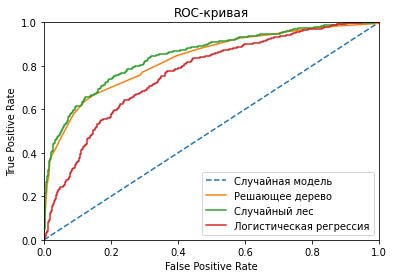

In [29]:
#Исследуем метрику AUC-ROC для решающего дерева
model = DecisionTreeClassifier(random_state=12345, max_depth=5) # обучим модель с заданной глубиной дерева
model.fit(features_upsampled, target_upsampled) # обучим модель вызовом метода fit()

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr_tree, tpr_tree, thresholds = roc_curve(target_valid, probabilities_valid[:, 1])

#Исследуем метрику AUC-ROC для случайного леса
model = RandomForestClassifier(random_state=12345, max_depth=13, n_estimators=120) # обучим модель с заданной глубиной дерева
model.fit(features_upsampled, target_upsampled) # обучим модель вызовом метода fit()

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr_forest, tpr_forest, thresholds = roc_curve(target_valid, probabilities_valid[:, 1])

#Исследуем метрику AUC-ROC для логистической регрессии
model = LogisticRegression(solver='liblinear', random_state=12345, class_weight='balanced')
model.fit(features_upsampled, target_upsampled) # обучим модель вызовом метода fit()

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr_regression, tpr_regression, thresholds = roc_curve(target_valid, probabilities_valid[:, 1])

#Построим графики
plt.figure()

#ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')
plt.plot(fpr_tree, tpr_tree, label='Решающее дерево')
plt.plot(fpr_forest, tpr_forest, label='Случайный лес')
plt.plot(fpr_regression, tpr_regression, label='Логистическая регрессия')

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

In [30]:
#Посчитаем AUC-ROC
model = RandomForestClassifier(random_state=12345, max_depth=13, n_estimators=120) # обучим модель с заданной глубиной дерева
model.fit(features_upsampled, target_upsampled) # обучим модель вызовом метода fit()

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.8472906925398774


AUC-ROC = 0,84, что довольно далеко до идеального (AUC-ROC = 1)

### Вывод
1. Применили разные способы борьбы с дисбалансом: взвешивания классов, увеличения выборки, уменьшение выборки
2. Нашли ниулучшую модель - "Случайны лес" с параметрами глубина 13 и количество деревьев 120
3. Показатель AUC-ROC лучшей модели = 0,84

## Тестирование модели

In [31]:
#Проверим модель на тестовой выборке
model = RandomForestClassifier(random_state=12345, max_depth=13, n_estimators=120) # обучим модель с заданной глубиной дерева
model.fit(features_upsampled, target_upsampled) # обучим модель вызовом метода fit()
predicted_test = model.predict(features_test) # получим предсказания модели
print('f1', f1_score(target_test, predicted_test)) # напечатаем f1

f1 0.6057692307692307


In [32]:
#Посчитаем AUC-ROC
model = RandomForestClassifier(random_state=12345, max_depth=13, n_estimators=120) # обучим модель с заданной глубиной дерева
model.fit(features_upsampled, target_upsampled) # обучим модель вызовом метода fit()

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('AUC-ROC', auc_roc)

AUC-ROC 0.8523410551500514


In [33]:
#Посчитаем долю правильных ответов, полноту
model = RandomForestClassifier(random_state=12345, max_depth=13, n_estimators=120) # обучим модель с заданной глубиной дерева
model.fit(features_upsampled, target_upsampled) # обучим модель вызовом метода fit()
predicted_test = model.predict(features_test) # получим предсказания модели
print('Полнота', recall_score(target_test, predicted_test)) # напечатаем

Полнота 0.5957446808510638


In [34]:
#Посчитаем точность, какая доля объектов, отмеченных моделью как положительные, на самом деле такие
model = RandomForestClassifier(random_state=12345, max_depth=13, n_estimators=120) # обучим модель с заданной глубиной дерева
model.fit(features_upsampled, target_upsampled) # обучим модель вызовом метода fit()
predicted_test = model.predict(features_test) # получим предсказания модели
print('Точность', precision_score(target_test, predicted_test)) # напечатаем

Точность 0.6161369193154034


In [35]:
#Создадим константную модель
target_pred_constant = pd.Series(0, index=target_test.index)
#Посчитаем AUC-ROC
print('AUC-ROC', roc_auc_score(target_test, target_pred_constant))

AUC-ROC 0.5


AUC-ROC константной модели значительно хуже, 0,5 против 0,85

### Вывод
1. Проверили модель на тестовой выборке, AUC-ROC стал лучше, 0,85 против 0,84
2. Сравнили с константной моделью, 0,85 против 0,5

## Общие выводы

1. Наилучшая модель "Случайны лес", при глубине 13 и количестве деревьев 120
2. AUC-ROC на тестовой выборке = 0,85, что далеко до идеального (AUC-ROC = 1), но в тоже время неплохой результат
3. Полнота 0.59, точность 0,61

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*